In [1]:
import networkx as nx
from MaxCutSolver import MaxCutSolver
import matplotlib.pyplot as plt
from numpy import pi 
import time

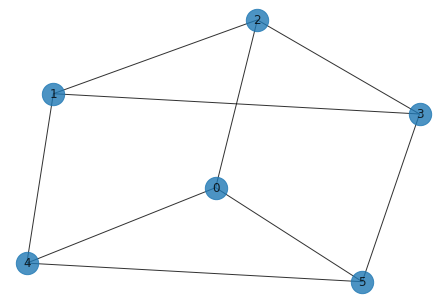

In [2]:
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3])
G.add_edges_from([(0, 2), (0, 4), (0, 5), (1,3), (1,2), (1,4), (2,3), (3,5), (4,5)])
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

# Comparison between the optimizers

## Statevector simulator

In [18]:
gradient_values_nm_p = list()
gradient_values_cobyla_p = list()
gradient_values_slsqp_p = list()
swarm_values_p = list()
bats_values_p = list()
ants_values_p = list() 
bees_values_p = list()
gradient_values_nm = list()
gradient_values_cobyla = list()
gradient_values_slsqp = list()
swarm_values = list()
bats_values = list()
ants_values = list()
bees_values = list()
gradient_time_nm = list()
gradient_time_cobyla = list()
gradient_time_slsqp = list()
swarm_time = list()
bats_time = list()
ants_time = list()
bees_time = list()
gradient_iterations_nm = list()
gradient_iterations_cobyla = list()
gradient_iterations_slsqp = list()
swarm_iterations = list()
bats_iterations = list()
ants_iterations = list()
bees_iterations = list()
p_range = 8
for i in range(1, p_range):
    myanzats = MaxCutSolver(graph=G, num_qubits=6, backend='statevector_simulator', p=i)
    start_time = time.time()
    opt_nm = myanzats.optimize_classic(method='Nelder-Mead')
    gradient_dict_nm = myanzats.output_circuit(opt_nm.x)
    gradient_time_nm.append(time.time() - start_time)
    start_time = time.time()
    opt_cobyla = myanzats.optimize_classic(method='COBYLA')
    gradient_dict_cobyla = myanzats.output_circuit(opt_cobyla.x)
    gradient_time_cobyla.append(time.time() - start_time)
    start_time = time.time()
    opt_slsqp = myanzats.optimize_classic(method='SLSQP')
    gradient_dict_slsqp = myanzats.output_circuit(opt_slsqp.x)
    gradient_time_slsqp.append(time.time() - start_time)
    start_time = time.time()
    swarm_dict = myanzats.output_circuit(myanzats.optimize_swarm([0,pi]))
    swarm_time.append(time.time() - start_time)
    start_time = time.time()
    bats_dict = myanzats.output_circuit(myanzats.optimize_bats([0,pi]))
    bats_time.append(time.time() - start_time)
    start_time = time.time()
    opt_ants,iter_ants = myanzats.optimize_ants([0,pi])
    ants_dict = myanzats.output_circuit(opt_ants)
    ants_time.append(time.time() - start_time)

    print("empezando abejas")
    start_time = time.time()
    opt_bees = myanzats.optimize_bees([0,2*pi])
    bees_dict = myanzats.output_circuit(opt_bees)
    bees_time.append(time.time() - start_time)

    bats_values_p.append(bats_dict['110001']/max(bats_dict.values()))
    swarm_values_p.append(swarm_dict['110001']/max(swarm_dict.values()))
    gradient_values_nm_p.append(gradient_dict_nm['110001']/max(gradient_dict_nm.values()))
    gradient_values_cobyla_p.append(gradient_dict_cobyla['110001']/max(gradient_dict_cobyla.values()))
    gradient_values_slsqp_p.append(gradient_dict_slsqp['110001']/max(gradient_dict_slsqp.values()))
    ants_values_p.append(ants_dict['110001']/max(ants_dict.values()))
    bees_values_p.append(bees_dict['110001']/max(bees_dict.values()))
    bats_values.append(bats_dict['110001'])
    swarm_values.append(swarm_dict['110001'])
    gradient_values_nm.append(gradient_dict_nm['110001'])
    gradient_values_cobyla.append(gradient_dict_cobyla['110001'])
    gradient_values_slsqp.append(gradient_dict_slsqp['110001'])
    ants_values.append(ants_dict['110001'])
    bees_values.append(bees_dict['110001'])
    gradient_iterations_nm.append(opt_nm.nit)
    #gradient_iterations_cobyla.append(opt_cobyla.nit)
    gradient_iterations_slsqp.append(opt_slsqp.nit)
    swarm_iterations.append(100)
    bats_iterations.append(50)
    bees_iterations.append(30)
    ants_iterations.append(iter_ants)

[0.25 0.25]
[0.25 0.25]
[0.25 0.25]
iteration 0 with cost of -5.041192644454018
empezando abejas
[0.125 0.375 0.375 0.125]
[0.125 0.375 0.375 0.125]
[0.125 0.375 0.375 0.125]
iteration 0 with cost of -4.761650464508141
empezando abejas
[0.08333333 0.41666667 0.25       0.25       0.41666667 0.08333333]
[0.08333333 0.41666667 0.25       0.25       0.41666667 0.08333333]
[0.08333333 0.41666667 0.25       0.25       0.41666667 0.08333333]
iteration 0 with cost of -4.89651916338658
empezando abejas
[0.0625 0.4375 0.1875 0.3125 0.3125 0.1875 0.4375 0.0625]
[0.0625 0.4375 0.1875 0.3125 0.3125 0.1875 0.4375 0.0625]
[0.0625 0.4375 0.1875 0.3125 0.3125 0.1875 0.4375 0.0625]
iteration 0 with cost of -4.708489268818952
empezando abejas
[0.05 0.45 0.15 0.35 0.25 0.25 0.35 0.15 0.45 0.05]
[0.05 0.45 0.15 0.35 0.25 0.25 0.35 0.15 0.45 0.05]
[0.05 0.45 0.15 0.35 0.25 0.25 0.35 0.15 0.45 0.05]
iteration 0 with cost of -4.991325273887977
empezando abejas
[0.04166667 0.45833333 0.125      0.375      0.2

### Approximation ratio vs p-value

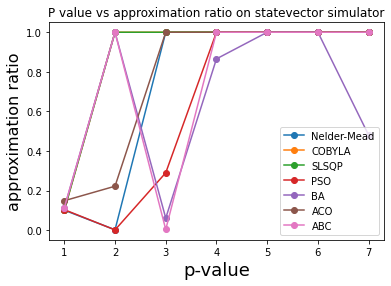

In [19]:
plt.plot(list(range(1,p_range)), gradient_values_nm_p, '-o')
plt.plot(list(range(1,p_range)), gradient_values_cobyla_p, '-o')
plt.plot(list(range(1,p_range)), gradient_values_slsqp_p, '-o')
plt.plot(list(range(1,p_range)), swarm_values_p, '-o')
plt.plot(list(range(1,p_range)), bats_values_p, '-o')
plt.plot(list(range(1,p_range)), ants_values_p, '-o')
plt.plot(list(range(1,p_range)), bees_values_p, '-o')
plt.legend(["Nelder-Mead", "COBYLA","SLSQP","PSO", "BA", "ACO","ABC"])
plt.title("P value vs approximation ratio on statevector simulator")
plt.xlabel('p-value', fontsize=18)
plt.ylabel('approximation ratio', fontsize=16)
plt.show()

### Ground state probability vs p-value

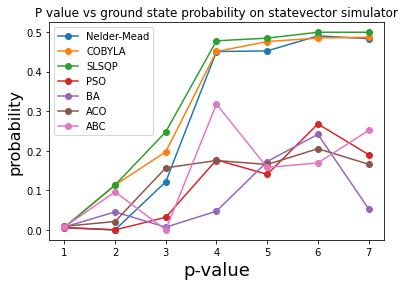

In [20]:
plt.plot(list(range(1,p_range)), gradient_values_nm, '-o')
plt.plot(list(range(1,p_range)), gradient_values_cobyla, '-o')
plt.plot(list(range(1,p_range)), gradient_values_slsqp, '-o')
plt.plot(list(range(1,p_range)), swarm_values, '-o')
plt.plot(list(range(1,p_range)), bats_values, '-o')
plt.plot(list(range(1,p_range)), ants_values, '-o')
plt.plot(list(range(1,p_range)), bees_values, '-o')
plt.legend(["Nelder-Mead", "COBYLA","SLSQP","PSO", "BA", "ACO", "ABC"])
plt.title("P value vs ground state probability on statevector simulator")
plt.xlabel('p-value', fontsize=18)
plt.ylabel('probability', fontsize=16)
plt.show()

### Execution time

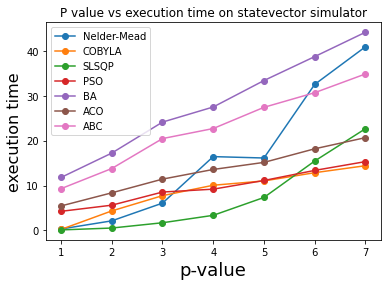

In [21]:
plt.plot(list(range(1,p_range)), gradient_time_nm, '-o')
plt.plot(list(range(1,p_range)), gradient_time_cobyla, '-o')
plt.plot(list(range(1,p_range)), gradient_time_slsqp, '-o')
plt.plot(list(range(1,p_range)), swarm_time, '-o')
plt.plot(list(range(1,p_range)), bats_time, '-o')
plt.plot(list(range(1,p_range)), ants_time, '-o')
plt.plot(list(range(1,p_range)), bees_time, '-o')
plt.legend(["Nelder-Mead", "COBYLA","SLSQP","PSO", "BA", "ACO", "ABC"])
plt.title("P value vs execution time on statevector simulator")
plt.xlabel('p-value', fontsize=18)
plt.ylabel('execution time', fontsize=16)
plt.show()

## Qasm simulator

In [23]:
gradient_values_nm_p = list()
gradient_values_cobyla_p = list()
gradient_values_slsqp_p = list()
swarm_values_p = list()
bats_values_p = list()
ants_values_p = list()
bees_values_p = list()
gradient_values_nm = list()
gradient_values_cobyla = list()
gradient_values_slsqp = list()
swarm_values = list()
bats_values = list()
ants_values = list()
bees_values = list()
gradient_time_nm = list()
gradient_time_cobyla = list()
gradient_time_slsqp = list()
swarm_time = list()
bats_time = list()
ants_time = list()
bees_time = list()
gradient_iterations_nm = list()
gradient_iterations_cobyla = list()
gradient_iterations_slsqp = list()
swarm_iterations = list()
bats_iterations = list()
ants_iterations = list()
bees_iterations = list()
p_range = 8
for i in range(1, p_range):
    myanzats = MaxCutSolver(graph=G, num_qubits=6, backend='qasm_simulator', p=i)
    start_time = time.time()
    opt_gradient_nm = myanzats.optimize_classic(method='Nelder-Mead')
    gradient_time_nm.append(time.time() - start_time)
    start_time = time.time()
    opt_gradient_cobyla = myanzats.optimize_classic(method='COBYLA').x
    gradient_time_cobyla.append(time.time() - start_time)
    start_time = time.time()
    opt_gradient_slsqp = myanzats.optimize_classic(method='SLSQP')
    gradient_time_slsqp.append(time.time() - start_time)
    start_time = time.time()
    opt_bats = myanzats.optimize_bats([0,pi])
    bats_time.append(time.time() - start_time )
    start_time = time.time()
    opt_ants,iter_ants = myanzats.optimize_ants([-5,5])
    ants_time.append(time.time() - start_time)
    start_time = time.time()
    opt_swarm = myanzats.optimize_swarm([-5,5])
    swarm_time.append(time.time() - start_time)
    start_time = time.time()
    opt_bee = myanzats.optimize_bees([0,2*pi])
    bees_time.append(time.time() - start_time)


    gradient_iterations_nm.append(opt_gradient_nm.nit)
    gradient_iterations_slsqp.append(opt_gradient_slsqp.nit)
    opt_gradient_nm = myanzats.optimize_classic(method='Nelder-Mead').x
    opt_gradient_slsqp = myanzats.optimize_classic(method='SLSQP').x
    
    swarm_iterations.append(100)
    bats_iterations.append(50)
    ants_iterations.append(iter_ants)
    bees_iterations.append(10)
    mean_gradient_p_nm = 0
    mean_gradient_p_cobyla = 0
    mean_gradient_p_slsqp = 0
    mean_ants_p = 0
    mean_bats_p = 0
    mean_swarm_p = 0
    mean_bees_p = 0
    mean_gradient_nm = 0
    mean_gradient_cobyla = 0
    mean_gradient_slsqp = 0
    mean_ants = 0
    mean_bats = 0
    mean_swarm = 0
    mean_bees = 0

    for i in range(0,30):

        gradient_dict_nm = myanzats.output_circuit(opt_gradient_nm)
        gradient_dict_cobyla = myanzats.output_circuit(opt_gradient_cobyla)
        gradient_dict_slsqp = myanzats.output_circuit(opt_gradient_slsqp)
        swarm_dict = myanzats.output_circuit(opt_swarm)
        bats_dict = myanzats.output_circuit(opt_bats)
        ants_dict = myanzats.output_circuit(opt_ants)
        bees_dict = myanzats.output_circuit(opt_bee)

        mean_bats_p = 0 if not '110001' in bats_dict else bats_dict['110001']/max(bats_dict.values())
        mean_swarm_p = 0 if not '110001' in swarm_dict else swarm_dict['110001']/max(swarm_dict.values())
        mean_gradient_p_nm = 0 if not '110001' in gradient_dict_nm else gradient_dict_nm['110001']/max(gradient_dict_nm.values())
        mean_gradient_p_cobyla = 0 if not '110001' in gradient_dict_cobyla else gradient_dict_cobyla['110001']/max(gradient_dict_cobyla.values())
        mean_gradient_p_slsqp = 0 if not '110001' in gradient_dict_slsqp else gradient_dict_slsqp['110001']/max(gradient_dict_slsqp.values())
        mean_ants_p = 0 if not '110001' in ants_dict else ants_dict['110001']/max(ants_dict.values())
        mean_bees_p = 0 if not '110001' in bees_dict else bees_dict['110001']/max(bees_dict.values())
        

        mean_gradient_nm += 0 if not '110001' in gradient_dict_nm else gradient_dict_nm['110001']  
        mean_gradient_cobyla += 0 if not '110001' in gradient_dict_cobyla else gradient_dict_cobyla['110001']
        mean_gradient_slsqp += 0 if not '110001' in gradient_dict_slsqp else gradient_dict_slsqp['110001'] 
        mean_swarm += 0 if not '110001' in swarm_dict else swarm_dict['110001'] 
        mean_bats += 0 if not '110001' in bats_dict else bats_dict['110001'] 
        mean_ants += 0 if not '110001' in ants_dict else ants_dict['110001']
        mean_bees += 0 if not '110001' in bees_dict else bees_dict['110001']


    bats_values.append(mean_bats/30)
    swarm_values.append(mean_swarm/30)
    gradient_values_nm.append(mean_gradient_nm/30)
    gradient_values_cobyla.append(mean_gradient_cobyla/30)
    gradient_values_slsqp.append(mean_gradient_slsqp/30)
    ants_values.append(mean_ants/30)
    bees_values.append(mean_bees/30)
    bats_values_p.append(mean_bats_p/30)
    swarm_values_p.append(mean_swarm_p/30)
    gradient_values_nm_p.append(mean_gradient_p_nm/30)
    gradient_values_cobyla_p.append(mean_gradient_p_cobyla/30)
    gradient_values_slsqp_p.append(mean_gradient_p_slsqp/30)
    ants_values_p.append(mean_ants_p/30)
    bees_values_p.append(mean_bees_p/30)

[0.25 0.25]
[0.25 0.25]
[0.25 0.25]
iteration 0 with cost of -5.0537109375
[0.25 0.25]
[0.25 0.25]
[0.125 0.375 0.375 0.125]
[0.125 0.375 0.375 0.125]
[0.125 0.375 0.375 0.125]
iteration 0 with cost of -4.83984375
[0.125 0.375 0.375 0.125]
[0.125 0.375 0.375 0.125]
[0.08333333 0.41666667 0.25       0.25       0.41666667 0.08333333]
[0.08333333 0.41666667 0.25       0.25       0.41666667 0.08333333]
[0.08333333 0.41666667 0.25       0.25       0.41666667 0.08333333]
iteration 0 with cost of -5.1484375
[0.08333333 0.41666667 0.25       0.25       0.41666667 0.08333333]
[0.08333333 0.41666667 0.25       0.25       0.41666667 0.08333333]
[0.0625 0.4375 0.1875 0.3125 0.3125 0.1875 0.4375 0.0625]
[0.0625 0.4375 0.1875 0.3125 0.3125 0.1875 0.4375 0.0625]
[0.0625 0.4375 0.1875 0.3125 0.3125 0.1875 0.4375 0.0625]
iteration 0 with cost of -5.3056640625
[0.0625 0.4375 0.1875 0.3125 0.3125 0.1875 0.4375 0.0625]
[0.0625 0.4375 0.1875 0.3125 0.3125 0.1875 0.4375 0.0625]
[0.05 0.45 0.15 0.35 0.25 0.2

### Approximation ratio vs p-value

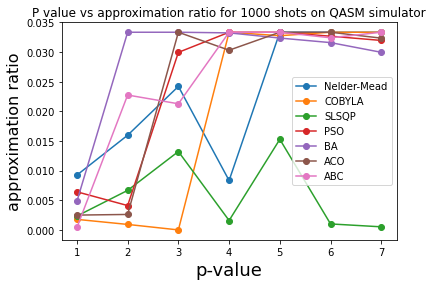

In [24]:
plt.plot(list(range(1,p_range)), gradient_values_nm_p, '-o')
plt.plot(list(range(1,p_range)), gradient_values_cobyla_p, '-o')
plt.plot(list(range(1,p_range)), gradient_values_slsqp_p, '-o')
plt.plot(list(range(1,p_range)), swarm_values_p, '-o')
plt.plot(list(range(1,p_range)), bats_values_p, '-o')
plt.plot(list(range(1,p_range)), ants_values_p, '-o')
plt.plot(list(range(1,p_range)), bees_values_p, '-o')
plt.legend(["Nelder-Mead", "COBYLA","SLSQP","PSO", "BA", "ACO", "ABC"])
plt.title("P value vs approximation ratio for 1000 shots on QASM simulator")
plt.xlabel('p-value', fontsize=18)
plt.ylabel('approximation ratio', fontsize=16)
plt.show()

### Ground state probability vs p-value

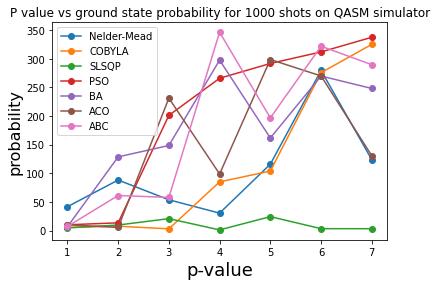

In [25]:
plt.plot(list(range(1,p_range)), gradient_values_nm, '-o')
plt.plot(list(range(1,p_range)), gradient_values_cobyla, '-o')
plt.plot(list(range(1,p_range)), gradient_values_slsqp, '-o')
plt.plot(list(range(1,p_range)), swarm_values, '-o')
plt.plot(list(range(1,p_range)), bats_values, '-o')
plt.plot(list(range(1,p_range)), ants_values, '-o')
plt.plot(list(range(1,p_range)), bees_values, '-o')
plt.legend(["Nelder-Mead", "COBYLA","SLSQP","PSO", "BA", "ACO","ABC"])
plt.title("P value vs ground state probability for 1000 shots on QASM simulator")
plt.xlabel('p-value', fontsize=18)
plt.ylabel('probability', fontsize=16)
plt.show()

### Execution time vs p-value

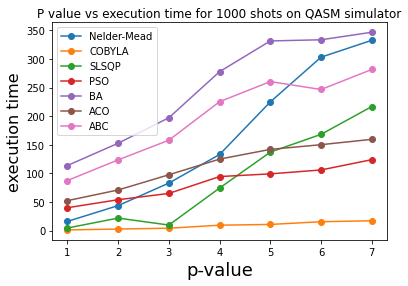

In [26]:
plt.plot(list(range(1,p_range)), gradient_time_nm, '-o')
plt.plot(list(range(1,p_range)), gradient_time_cobyla, '-o')
plt.plot(list(range(1,p_range)), gradient_time_slsqp, '-o')
plt.plot(list(range(1,p_range)), swarm_time, '-o')
plt.plot(list(range(1,p_range)), bats_time, '-o')
plt.plot(list(range(1,p_range)), ants_time, '-o')
plt.plot(list(range(1,p_range)), bees_time, '-o')
plt.legend(["Nelder-Mead", "COBYLA","SLSQP","PSO", "BA", "ACO", "ABC"])
plt.title("P value vs execution time for 1000 shots on QASM simulator")
plt.xlabel('p-value', fontsize=18)
plt.ylabel('execution time', fontsize=16)
plt.show()